In [1]:
import sys
sys.path.insert(1, '../')
import os 
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pydicom as dcm
import math
from numpy import sqrt, sin, cos, pi, exp, log
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.optimize
import scipy as scipy
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [2]:
[height, width, N] = [224, 224, 224*6]

In [6]:
# read image sizes then clear the memory 
filePath = "../lib/resource/data/UTE/UTE_ANKLE"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
dirs = np.sort(dirs)
images = np.zeros([height,width,N])

for index,f in enumerate (dirs):
    image = dcm.read_file(f)
    data = apply_voi_lut(image.pixel_array, image)
    images[:,:,index] = data

In [7]:
images_TE02 = images[:,:,0:224] #  0.2ms
images_TE08 = images[:,:,224:448] # 0.8ms 
images_TE20 = images[:,:,448:672] # 2ms 

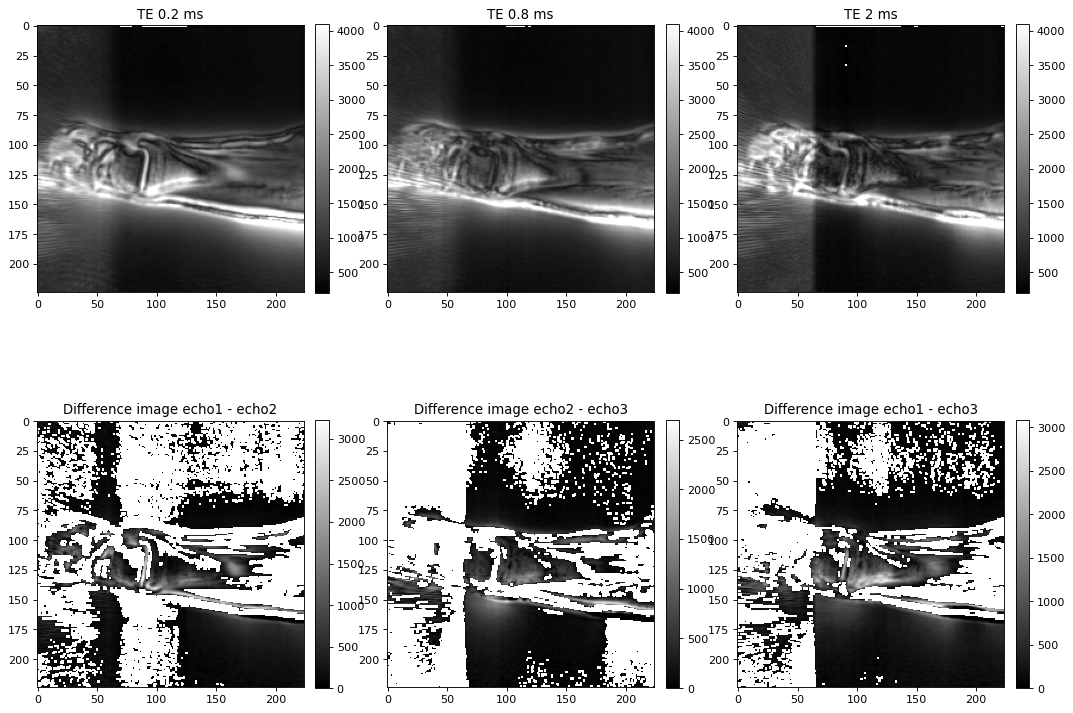

In [8]:
#%matplotlib qt 
%matplotlib inline
slice = 100
plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(231)
i1 = images_TE02[slice,:,:]
i1[i1 < 200] = np.nan
tf = plt.imshow(i1,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("TE 0.2 ms")
plt.subplot(232)
i2 = images_TE08[slice,:,:]
i2[i2 < 200] = np.nan
tf = plt.imshow(i2,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("TE 0.8 ms")
plt.subplot(233)
i3 = images_TE20[slice,:,:]
i3[i3 < 200] = np.nan
tf = plt.imshow(i3,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("TE 2 ms")
plt.subplot(234)
d1 = images_TE02[slice,:,:]- images_TE08[slice,:,:]
d1[d1 < 0 ] = np.nan
tf = plt.imshow(d1,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("Difference image echo1 - echo2")
plt.subplot(235)
d2 = images_TE08[slice,:,:]- images_TE20[slice,:,:]
d2[d2 < 0 ] = np.nan
tf = plt.imshow(d2,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("Difference image echo2 - echo3")
plt.subplot(236)
d3 = images_TE02[slice,:,:]- images_TE20[slice,:,:]
d3[d3 < 0 ] = np.nan
tf = plt.imshow(d3,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("Difference image echo1 - echo3")
plt.show()

In [9]:
def monoExp(TE, A, T2s):
    return A * np.exp(-TE/T2s) 

[1.11925444e+03 1.05336602e+00]
1.0533660247479386


/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


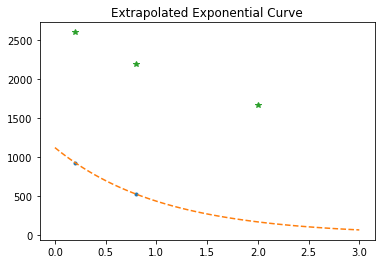

In [10]:
slice = 80
xx = 88
yy = 130
xs = [0.2,0.8]
ys = np.array([images_TE02[slice,yy,xx]-images_TE20[slice,yy,xx],images_TE08[slice,yy,xx] - images_TE20[slice,yy,xx]])
p0 = (200, 20, 100) 
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, bounds=((-np.inf, 0),(np.inf, np.inf)))
m, t2 = params
xs2 = np.linspace(0,3,100)
ys2 = monoExp(xs2, m, t2)
plt.plot(xs, ys, '.')
plt.plot(xs2, ys2, '--')
xxn = [0.2,0.8,2]
yyn = np.array([images_TE02[slice,yy,xx],images_TE08[slice,yy,xx],images_TE20[slice,yy,xx]])

plt.plot(xxn, yyn, '*')
plt.title("Extrapolated Exponential Curve")
print(params)
print(t2)

In [11]:
slice = 80
xs = [0.2,0.8,2]
p0 = (2000, 0.2) 
t2map = np.zeros([height,width])
for y in range(height):
    for x in range(width):
        try:
            ys = np.array([images_TE02[slice,y,x],images_TE08[slice,y,x],images_TE20[slice,y,x]])
            params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
            m, t2 = params
            t2map[y,x] = t2
        except RuntimeError:
            t2map[y,x] = np.nan

/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


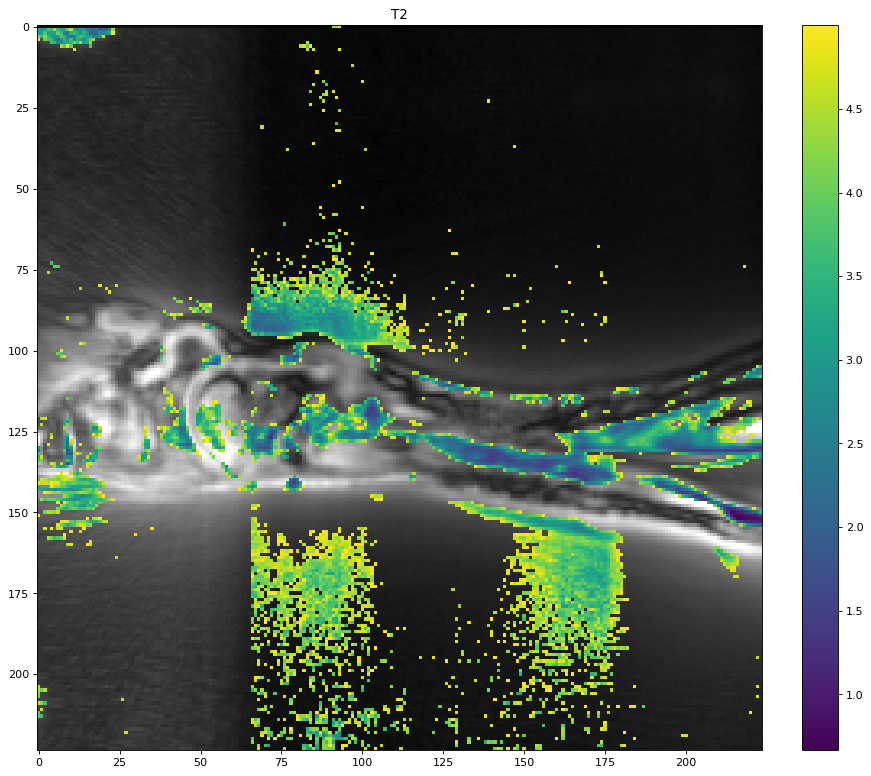

In [12]:
t2map[t2map>=5] = np.nan
t2map[t2map<=0] = np.nan
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(images_TE02[slice,:,:],cmap ="gray")
tf = plt.imshow(t2map)
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("T2")
plt.show()